**deepSISOCSIR**<br>
By $\text{Rishabh Pomaje}$

- Autoencoder based SISO system with **CSI** available only at the receiver
- Objectives : 
    - To learn a (4, 7) system under the following conditions :
        1. Flat-fading, Fast-fading  
        2. Rayleigh Channel with AWGN 
        3. Channel Model : $y_i = h_i x_i + w_i$
            - where, $h \overset{i.i.d}{\sim} \mathcal{CN}(0, 1)$ and $w \overset{i.i.d}{\sim} \mathcal{CN}(0, N_0)$

**Definitions**
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{2N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times N_0}{2 \times E_b} = \frac{N_0}{2a} = N_0 / 2 \;\dots (a = 1) 
\end{equation*}


Also, 

\begin{equation*}
\frac{1}{2 \times R \times SNR_{linear}} = \frac{1 \times n \times N_0}{2 \times k \times E_b} = \frac{nN_0}{2k}
\end{equation*}

In [1]:
# Dependencies :
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
%config InlineBackend.figure_format='svg'
TF_ENABLE_ONEDNN_OPTS = 0 
print(tf.__version__)

2.16.1


- We are restraining to using only BPSK mapping
We define SNR as follows :
\begin{equation}
\text{SNR}_{linear} = \frac{E_b}{N_0} = \frac{\text{Received signal energy per bit}}{\text{Noise Spectral density}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 $
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

System Specification Parameters/ Constants 

In [2]:
M = 2 ** 4                  # Size of alphabet
k = 4                       # Number of bits required
n = 7                       # Size of coded vector 
R = k / n                   # Information/ Communication rate 

Generation of the training data 

In [3]:
training_set_size = 10 ** 6 # Equivalent to k Million bits 

# Random indices
sample_indices = np.random.randint(0, M, training_set_size)

# Converting the indices to 1-hot vectors
x_train = np.zeros((training_set_size, M))  
x_train[np.arange(training_set_size), sample_indices] = 1  # One-hot encoding
print(f'Samples = {x_train}')
# Since we are reproducing the input at the output :
y_train = x_train 

# Generate random fading taps for training == CSI @ Rx
fading_mean = 0 
fading_std = np.sqrt(0.5)
fading_taps_real = np.random.normal(fading_mean, fading_std, (training_set_size, n)) 
fading_taps_imag = np.random.normal(fading_mean, fading_std, (training_set_size, n))

Samples = [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Creating the Autoencoder

In [4]:
# Description of the encoder(transmitter) part :
enc_input_layer = tf.keras.Input(shape=(M,), name="Input Layer")
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Encoder_Hidden_01")(enc_input_layer)
enc_layer_02 = tf.keras.layers.Dense(n, activation='linear', name="Encoder_Hidden_02")(enc_layer_01)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_02)

# Describing the AWGN Channel with Rayleigh fading :
fading_layer_real = tf.keras.Input(shape=(n, ), name='fading_layer_real')
fading_layer_imag = tf.keras.Input(shape=(n,), name='fading_layer_imag')
# y = fx + w  model(flat + fast fading):
rx_signal_real = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_real])
rx_signal_imag = tf.keras.layers.Multiply()([enc_layer_normalized, fading_layer_imag])

# Adding the Gaussian noise :
SNR_dB = 7 
SNR_lin = 10 ** (SNR_dB / 10)
rx_noisy_signal_real = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_real')(rx_signal_real)
rx_noisy_signal_imag = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_imag')(rx_signal_imag)

# Description of the decoder(receiver) part :
# Concatenating the I and Q noisy signal at the decoder part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_real, rx_noisy_signal_imag, fading_layer_real, fading_layer_imag])
dec_layer_01 = tf.keras.layers.Dense(4*M, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_02)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer, fading_layer_real, fading_layer_imag], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input Layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_01   │ (None, 16)        │        272 │ Input Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder_Hidden_02   │ (None, 7)         │        119 │ Encoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 7)         │          0 │ Encoder_Hidden_0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_layer_real   │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_layer_imag   │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7)         │          0 │ Power_Constraint… │
│                     │                   │            │ fading_layer_rea… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7)         │          0 │ Power_Constraint… │
│ (Multiply)          │                   │            │ fading_layer_ima… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_real   │ (None, 7)         │          0 │ multiply[0][0]    │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_imag   │ (None, 7)         │          0 │ multiply_1[0][0]  │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28)        │          0 │ AWGN_channel_rea… │
│ (Concatenate)       │                   │            │ AWGN_channel_ima… │
│                     │                   │            │ fading_layer_rea… │
│                     │                   │            │ fading_layer_ima… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 64)        │      1,856 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 16)        │      1,040 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 16)        │        272 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,559 (13.90 KB)

 Trainable params: 3,559 (13.90 KB)

 Non-trainable params: 0 (0.00 B)

Training the above autoencoder

In [5]:
autoencoder.fit([x_train, fading_taps_real, fading_taps_imag], y_train, batch_size=1000, epochs=100)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3966 - loss: 1.8141
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8523 - loss: 0.4275
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9172 - loss: 0.2385
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9393 - loss: 0.1739
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9484 - loss: 0.1470
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9540 - loss: 0.1307
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9588 - loss: 0.1167
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9623 - loss: 0.1075
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9659 - loss: 0.0972
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9676 - loss: 0.0925
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9689 - loss: 0.0888
Epoch 12/100
1000/1

Testing the above encoder at various SNRs

Generation of testing/ validation data

In [6]:
test_data_size = 10 ** 6
y_test = np.random.randint(0, M, test_data_size)
x_test = []
for idx in y_test:
    temp = np.zeros(M)
    temp[idx] = 1
    x_test.append(temp)

x_test = tf.constant(x_test)
x_test

<tf.Tensor: shape=(1000000, 16), dtype=float64, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])>

Abstracting the learned encoder and decoder 

In [7]:
# Abstracting out the encoder :
encoder_model = tf.keras.Model(enc_input_layer, enc_layer_normalized)

# ABstracting out the decoder :
rx_noisy_signal_I = tf.keras.Input(shape=(n,))
rx_noisy_signal_Q = tf.keras.Input(shape=(n,))
fading_I = tf.keras.Input(shape=(n,))
fading_Q = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-4]([rx_noisy_signal_I, rx_noisy_signal_Q, fading_I, fading_Q])
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

decoder_model = tf.keras.Model([rx_noisy_signal_I, rx_noisy_signal_Q, fading_I, fading_Q], decoder_output)

Validation Routine

In [3]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin) 

In [9]:
BLER_learned_coded_csir = []
for noise in noise_var :
    # Encoding 
    encoded_signal = encoder_model.predict(x_test)
    # Fading 
    fade_taps = np.random.normal(fading_mean, fading_std, (test_data_size, n)) + 1j* np.random.normal(0, fading_std, (test_data_size, n))
    rx_faded_signal = fade_taps * encoded_signal
    # Noise
    awgn = np.random.normal(0, np.sqrt(noise), (test_data_size, n)) + 1j* np.random.normal(0, np.sqrt(noise), (test_data_size, n))
    rx_noisy_signal = rx_faded_signal + awgn 
    # Decoding 
    decoded_signal = decoder_model.predict([np.real(rx_noisy_signal), np.imag(rx_noisy_signal), np.real(fade_taps), np.imag(fade_taps)])
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_coded_csir.append(np.sum(estimated_vectors != y_test) / test_data_size)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 15s 467us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 862us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 16s 509us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 843us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 15s 481us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 842us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 15s 487us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 16s 523us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 28s 893us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 17s 530us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 28s 900us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 16s 522us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 29s 912us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 23s 747us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 762us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 29s 928us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 16s 514us/step


In [10]:
print(f'BLER_learned_coded_csir = {BLER_learned_coded_csir}')

BLER_learned_coded_csir = [0.460028, 0.406145, 0.351387, 0.298551, 0.247619, 0.197521, 0.154763, 0.117291, 0.085435, 0.06066, 0.041501, 0.027718, 0.017821, 0.011053, 0.006569, 0.003961, 0.002277, 0.001274, 0.000748, 0.000388, 0.000212, 0.00011, 5.4e-05, 4.1e-05, 2e-05, 1.7e-05, 8e-06, 6e-06, 4e-06, 1e-06]


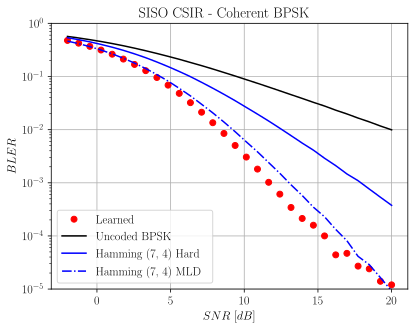

In [4]:
plt.rcParams.update({
    "text.usetex": True, # Comment this if TeX is not available in your machine
    "font.family" : 'serif',
    "font.size": 12
})
fig, axes = plt.subplots()
BLER_uncoded_coherent = [0.5680272, 0.5309792, 0.4934592, 0.4555216, 0.4171764, 0.379048, 0.341344, 0.3053108, 0.2713168, 0.2397304, 0.2108068, 0.1836344, 0.160064, 0.1383844, 0.118944, 0.1021392, 0.0871908, 0.0744648, 0.063376, 0.0537264, 0.0455488, 0.0386644, 0.0326556, 0.0278196, 0.023232, 0.0197452, 0.0165056, 0.0140056, 0.0117036, 0.0099112] 
BLER_coded_coherent_hard = [0.536786, 0.493408, 0.448528, 0.4018456, 0.3558564, 0.3107304, 0.2665516, 0.2256656, 0.1874048, 0.1535944, 0.1243256, 0.099286, 0.07765, 0.0602012, 0.0461896, 0.0350332, 0.0261992, 0.0195788, 0.014522, 0.0106236, 0.0077164, 0.005582, 0.0041124, 0.0028952, 0.0021004, 0.0014664, 0.0010936, 0.0007624, 0.000534, 0.000376] 
BLER_coded_coherent_mld = [0.4639776, 0.4149752, 0.3648816, 0.3149552, 0.2665676, 0.220544, 0.1786528, 0.1410548, 0.1087584, 0.0819908, 0.0598892, 0.0431796, 0.030006, 0.0206856, 0.0138944, 0.0091488, 0.0058908, 0.0038232, 0.0023984, 0.0015056, 0.0009156, 0.0005764, 0.0003476, 0.0002292, 0.0001324, 8.12e-05, 4.12e-05, 2.88e-05, 1.64e-05, 9.2e-06] 
BLER_learned_coded_csir = [0.477327, 0.423618, 0.369198, 0.314885, 0.262859, 0.2128, 0.168563, 0.128769, 0.095798, 0.068736, 0.048131, 0.032167, 0.021275, 0.013494, 0.008479, 0.005036, 0.003045, 0.001809, 0.001021, 0.000611, 0.000343, 0.000213, 0.000159, 0.0001, 4.4e-05, 4.7e-05, 2.7e-05, 2.4e-05, 1.4e-05, 1.2e-05]
axes.semilogy(SNR_dB, BLER_learned_coded_csir, label='Learned', color='red', marker="o", ls=" ")
axes.semilogy(SNR_dB, BLER_uncoded_coherent, label='Uncoded BPSK', color='black')
axes.semilogy(SNR_dB, BLER_coded_coherent_hard, label='Hamming (7, 4) Hard', color='blue')
axes.semilogy(SNR_dB, BLER_coded_coherent_mld, label='Hamming (7, 4) MLD', color='blue', ls="-.")
axes.set_xlabel(r'$SNR\ [dB]$')
axes.set_ylabel(r'$BLER$')
axes.set_ylim(10**-5, 10**0)
# axes.set_xlim(-4, 10)
axes.set_title(f'SISO CSIR - Coherent BPSK')
axes.legend()
axes.grid()

Saving the results for future reference

In [11]:
# Saving the plot :
fig.savefig("plots/deepSISOCSIR.svg", transparent=True)
# Saving the BLER :
with open("results/deepSISOCSIR.txt", mode='w') as file_id :
    file_id.write(f'BLER_learned_coded_csir = {BLER_learned_coded_csir}\n')
    file_id.write(f'BLER_uncoded_coherent = {BLER_uncoded_coherent}\n')
    file_id.write(f'BLER_coded_coherent_hard = {BLER_coded_coherent_hard}\n')
    file_id.write(f'BLER_coded_coherent_mld = {BLER_coded_coherent_mld}')